In [1]:
!pip install xgboost


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install --force-reinstall graphviz==0.18

  Using cached graphviz-0.18-py3-none-any.whl (38 kB)
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.18
    Uninstalling graphviz-0.18:
      Successfully uninstalled graphviz-0.18



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#LOADING THE REQUIERED LIBRARIES
import pandas as pd
import numpy as np
import time
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')
import re
import seaborn as sns
import matplotlib.pyplot as plt
#from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from gensim.models import Word2Vec
from lightgbm import LGBMRegressor

In [4]:
# LOADING THE TRAIN DATA
df =  pd.read_csv("train_processed.csv",index_col=["train_id"])
df

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,name_processed,brand_name_processed,category_name_preprocessed,Tier_1,Tier_2,Tier_3,processed_item_description
train_id,,,,,,,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895,mlb cincinnati reds shirt size xl,mlb,men/top/tshirts,men,top,tshirts,description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,razer blackwidow chroma keyboard,razer,electronic/computer tablet/component parts,electronic,computer tablet,component parts,keyboard great condition works like came box p...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,avaviv blouse,target,women/top blouse/blouse,women,top blouse,blouse,adorable top hint lace key hole back pale pink...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,leather horse statues,missing,home/home dcor/home dcor accents,home,home dcor,home dcor accents,new tags leather horses retail stand foot high...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,24k gold plated rose,missing,women/jewelry/necklaces,women,jewelry,necklaces,complete certificate authenticity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl...",3.044522,free people inspired dress,free people,women/dresse/midcalf,women,dresse,midcalf,lace says size small fits medium perfectly nev...
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t,2.708050,little mermaid handmade dress,disney,kid/girl 2t5t/dresses,kid,girl 2t5t,dresses,little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape.",2.564949,21 day fix containers eating plan,missing,sport outdoor/exercise/fitnes accessories,sport outdoor,exercise,fitnes accessories,used twice still great shape


In [5]:
# LOADING THE TEST DATASET
df_test = pd.read_csv("test_processed.csv",index_col=["test_id"])
df_test

,name,item_condition_id,category_name,brand_name,shipping,item_description,name_processed,brand_name_processed,category_name_preprocessed,Tier_1,Tier_2,Tier_3,processed_item_description
test_id,,,,,,,,,,,,,
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,breast cancer fight like girl ring,ring,women/jewelry/rings,women,jewelry,rings,size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",25 pcs new 75x12 kraft bubble mailers,missing,other/office supplie/shipping supplies,other,office supplie,shipping supplies,25 pcs new 75x12 kraft bubble mailers lined bu...
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,coach bag,coach,vintage collectible/bag and purse/handbag,vintage collectible,bag and purse,handbag,brand new coach bag bought coach outlet
3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,floral kimono,missing,women/sweater/cardigan,women,sweater,cardigan,floral kimono never worn lightweight perfect h...
4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,life death,missing,other/book/religion spirituality,other,book,religion spirituality,rediscovering life loss loved one tony cooke p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3460720,DARK SAMPLE BYE FOUNDATION MOISTURIZER,1,Beauty/Fragrance/Women,NaN,1,It cosmetics Bye Bye Foundation Full Coverage ...,dark sample bye foundation moisturizer,missing,beauty/fragrance/women,beauty,fragrance,women,cosmetics bye bye foundation full coverage moi...
3460721,bundle for @brandystash,2,Women/Pants/Other,NaN,1,♡2 pairs of omighty trackiez. one m and one s....,bundle brandystash,missing,women/pant/other,women,pant,other,2 pairs omighty trackiez one one prettiest pinks
3460722,Toddler High-top Converse,3,Kids/Girls 0-24 Mos/Shoes,Nike,0,Size 5 (toddler). Pink high top converse shoes...,toddler hightop converse,nike,kid/girl 024 mo/shoes,kid,girl 024 mo,shoes,size 5 toddler pink high top converse shoes st...


### Splitting the data

In [6]:
df_train,df_val = train_test_split(df,test_size=0.1,random_state = 3)

In [7]:
df_train.shape

(1334281, 15)

In [8]:
df_val.shape

(148254, 15)

In [9]:
df_test.shape

(3460725, 13)

### Value of Target variables

In [10]:
y_train = df_train.log_price
y_val = df_val.log_price

## A. Benchmark Model

In [11]:
'''THIS IS THE FIRST MODEL WHICH ACT AS BENCHMARK'''
# THIS MODEL IS BASED ON  ITEM CONDITION AND SHIPPING 
def benchmark(x_input):
    shipping = [0,1] #STORING ALL VALUES OF SHIPPING
    item_condition = [1,2,3,4,5] # STORING ALL VALUES OF ITEM CONDITION ID
    
    # HERE MODEL IS TAKING AVERAGE VALUES FOR ALL THE COMBINATIONS AND STORE IT IN THE FORM OF DICT 
    # THE KEY VALUE FOR THE DICTIONARY IS (shipping , item_condition_id)
    model = dict() 
    for i in shipping:
        for j in item_condition:
            model[(i,j)] = df[(df.shipping==i) & (df.item_condition_id==j)]["log_price"].mean()
    
    # HERE THE PREDICTION IS MADE FOR ALL THE INPUT DATASET
    output = [] # PLACEHOLDER FOR STORING OUTPUT
    for index,i in x_input.iterrows():
        output.append(model[(i.shipping,i.item_condition_id)])
    return np.array(output) # RESULTIN THE OUTPUT


In [12]:
'''PREDICTION THE VALUES FOR TRAIN AND VALIDATION DATASET'''
train_predict_benchmark = benchmark(df_train)
val_predict_benchmark = benchmark(df_val)

In [13]:
# PRINT RESULT OF TRAIN DATASET
print("Train Loss Benchmark Model =",np.sqrt(mean_squared_error(y_train,train_predict_benchmark)))

Train Loss Benchmark Model = 0.7267335100295781


In [14]:
# PRINTIN RESULT OF TEST DATASET
print("Val Loss Benchmark Model =",np.sqrt(mean_squared_error(y_val,val_predict_benchmark)))

Val Loss Benchmark Model = 0.7254971252489119


In [15]:
'''THIS IS UTILITY FUNCTIO WHICH CONVART LOG OUTPUT TO ACTUAL VALUES'''
def log_to_actual(log):
    return np.exp(log)-1

In [16]:
'''PREDICTIONS FOR TEST DATASET AND STOTING CSV FILE'''
test_predict_benchmark = benchmark(df_test)
test_predict_benchmark = pd.DataFrame(log_to_actual(test_predict_benchmark),columns=["price"])
test_predict_benchmark.index = df_test.index
test_predict_benchmark

,price
test_id,
0,14.913061
1,14.913061
2,14.913061
3,21.432196
4,15.587577
...,...
3460720,14.913061
3460721,15.814442
3460722,20.377879


In [17]:
# SROTING CSV FILE
test_predict_benchmark.to_csv("test_predict_benchmark.csv")

# 1. Feature Engineering

## Categorical Data : Label Encoding

## Text Data : Word 2 Vec

## Categorical Data

### 1. 'brand_name_processed'

In [18]:
'''BRAND NAME LABEL ENCODING'''
# brand_name_processed
label_brand = OrdinalEncoder( handle_unknown='use_encoded_value',unknown_value=-1) #creating an instance
label_brand.fit(df_train.brand_name_processed.values.reshape(-1,1))# fitting on train data 

train_vec_brand =label_brand.transform(df_train.brand_name_processed.values.reshape(-1,1)) #transformin the train data
val_vec_brand = label_brand.transform(df_val.brand_name_processed.values.reshape(-1,1)) # transforming the validation data

In [19]:
train_vec_brand.shape

(1334281, 1)

In [20]:
val_vec_brand.shape

(148254, 1)

In [21]:
'''VECTORIZING PROCESSED BRAND NAME IN TEST DATA '''
test_vec_brand = label_brand.transform(df_test.brand_name_processed.values.reshape(-1,1))
test_vec_brand.shape

(3460725, 1)

### 2. 'Tier_1'

In [22]:
'''TIER 1 LABEL ENCODING'''
label_t1 = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)#creating an instance
label_t1.fit(df_train.Tier_1.values.reshape(-1,1))# fitting on train data 

train_vec_t1 = label_t1.transform(df_train.Tier_1.values.reshape(-1,1))
val_vec_t1 =   label_t1.transform(df_val.Tier_1.values.reshape(-1,1))

In [23]:
train_vec_t1.shape

(1334281, 1)

In [24]:
val_vec_t1.shape

(148254, 1)

In [25]:
'''LABEL ENCODING TEST DATASET TIER 1'''
test_vec_t1 =   label_t1.transform(df_test.Tier_1.values.reshape(-1,1))
test_vec_t1.shape

(3460725, 1)

### 3. 'Tier_2'

In [26]:
'''TIER 2 LABEL ENCODING'''
label_t2 = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)#creating an instance
label_t2.fit(df_train.Tier_2.values.reshape(-1,1))# fitting on train data 

train_vec_t2 =label_t2.transform(df_train.Tier_2.values.reshape(-1,1))
val_vec_t2 = label_t2.transform(df_val.Tier_2.values.reshape(-1,1))

In [27]:
train_vec_t2.shape

(1334281, 1)

In [28]:
val_vec_t2.shape

(148254, 1)

In [29]:
'''LABEL ENCODING TEST DATASET TIER 2'''
test_vec_t2 = label_t2.transform(df_test.Tier_2.values.reshape(-1,1))
test_vec_t2 .shape

(3460725, 1)

## 4. 'Tier_3'

In [30]:
'''TIER 3 LABEL ENCODING'''
label_t3 = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)#creating an instance
label_t3.fit(df_train.Tier_3.values.reshape(-1,1))# fitting on train data 

train_vec_t3 =label_t3.transform(df_train.Tier_3.values.reshape(-1,1))
val_vec_t3 = label_t3.transform(df_val.Tier_3.values.reshape(-1,1))

In [31]:
train_vec_t3.shape

(1334281, 1)

In [32]:
train_vec_t3.shape

(1334281, 1)

In [33]:
'''LABEL ENCODING TEST DATASET TIER 3'''
test_vec_t3 = label_t3.transform(df_test.Tier_3.values.reshape(-1,1))
test_vec_t3 .shape

(3460725, 1)

## TEXT DATA

## 5. 'name_processed' + 'item_description'

In [34]:
'''CONCATINATIN NAME AND ITEM DESCRIPION TEXT FEATURES'''
df_train["concat"] = df_train.name_processed + " "+df_train.processed_item_description
df_val["concat"] = df_val.name_processed + " "+df_val.processed_item_description

In [35]:
'''CONCATINATIN NAME AND ITEM DESCRIPION TEXT FEATURES FOR TEST DATASET'''
df_test["concat"] = df_test.name_processed + " "+df_test.processed_item_description

### 'TEXT FEATURE' AVG 'Word2Vec

In [36]:
'''FORMIN CORPUR BY APPENDING WORDS IN A LIST'''
corpus_name = []
for i in tqdm(df_train.concat):
    corpus_name.append(str(i).split())

100%|████████████████████████████████████████████████████████████████████| 1334281/1334281 [00:10<00:00, 126653.29it/s]


In [37]:
'''TRAINING WORD 2 VEC'''
name_w2v = Word2Vec(corpus_name,vector_size=300,window= 20)

In [38]:
'''FUCTION FOR AVERAGE WORD2VEC'''
def sent_to_vec(text):
    vec= np.zeros(shape=(300,),dtype="float32")
    l = len(str(text).split())
    
    for i in str(text).split():
        try:
            vec += name_w2v.wv[i]
        except:
            continue
    if l !=0 :
        avg_vec = vec/l
    return avg_vec

In [39]:
'''APPLYING AVERAGE WORD2VEC TO ALL ROWS IN DATASET'''
train_vec_text = np.stack(df_train.concat.apply(sent_to_vec).values)
val_vec_text   = np.stack(df_val.concat.apply(sent_to_vec).values)

In [40]:
train_vec_text.shape

(1334281, 300)

In [41]:
val_vec_text.shape

(148254, 300)

In [42]:
'''APPLYING AVG WORD2VEC TO ALL ROWS IN TEST DATASET'''
test_vec_text   = np.stack(df_test.concat.apply(sent_to_vec).values)

## 6. 'is_missing' FEATURE

#### THIS FEATURES GIVES 1 IF A VALUE IS MISSING IN BRAND NAME OR NAME OR ITEM DESCRIPTION OTHERWISE 0

In [43]:
'''FEATURE FOR TRAIN DATASET'''
df_train["is_missing"]  =  (df_train.brand_name_processed=="missing") | (df_train.name_processed =="missing")| (df_train.processed_item_description=="missing")
df_train["is_missing"]  = df_train["is_missing"].astype(int)

In [44]:
'''FEATURE FOR VALIDARION DATASET'''
df_val["is_missing"]  =  (df_val.brand_name_processed=="missing") | (df_val.name_processed =="missing")| (df_val.processed_item_description=="missing")
df_val["is_missing"]  = df_val["is_missing"].astype(int)

In [45]:
'''FEATURE FOR TEST DATASET'''
df_test["is_missing"]  =  (df_test.brand_name_processed=="missing") | (df_test.name_processed =="missing")| (df_test.processed_item_description=="missing")
df_test["is_missing"]  = df_test["is_missing"].astype(int)

### Concatenating all Features

In [46]:
'''STACKING ALL FEATURES OF TRAIN DATASET'''
x_train = np.hstack((df_train.item_condition_id.values.reshape(-1,1) , df_train.shipping.values.reshape(-1,1) ,\
                     df_train.is_missing.values.reshape(-1,1) ,
            train_vec_brand , train_vec_t1 , train_vec_t2,train_vec_t3 , train_vec_text))

In [47]:
'''STACKING ALL FEATURES OF VALIDATION DATASET'''
x_val = np.hstack((df_val.item_condition_id.values.reshape(-1,1) , df_val.shipping.values.reshape(-1,1),\
                   df_val.is_missing.values.reshape(-1,1),  
                   val_vec_brand,val_vec_t1 , \
                  val_vec_t2,val_vec_t3,val_vec_text))

In [48]:
'''STACKING ALL FEATURES OF TEST DATASET'''
x_test = np.hstack((df_test.item_condition_id.values.reshape(-1,1) , df_test.shipping.values.reshape(-1,1),\
                   df_test.is_missing.values.reshape(-1,1),  
                   test_vec_brand,test_vec_t1 , \
                  test_vec_t2,test_vec_t3,
                    test_vec_text))

In [49]:
x_train.shape

(1334281, 307)

In [50]:
x_val.shape

(148254, 307)

## Sample Data for Hyperpatameter Tuning

#### CONSIDERING THE DATASET SIZE AND LOW COMPUTATION RESOURCES THIS DATASET IS SAMPLED FROM THE ORIGINAL DATASET. THIS IS ONLY USED FOR HYPERPARAMER TUNING . END TRAINING IS DONE ON FULL DATASET

In [51]:
'''THIS FUNCTION SAMPLES THE 50% OF THE DATA RANDOMLY'''
def sample(x_train,y_train):
    np.random.seed(5)
    index = np.random.random_integers(0,x_train.shape[0]-1,size=int(0.5*x_train.shape[0]))
    
    x_train_s = x_train[index]
    y_train_s = y_train.values[index]
    
    return x_train_s,y_train_s

In [52]:
x_train_s,y_train_s = sample(x_train,y_train)

In [53]:
print(x_train_s.shape)
print(y_train_s.shape)

(667140, 307)
(667140,)


# B. Models

## 1. Lasso

In [54]:
'''HYPERPARAMETER TUNING'''
laso = Lasso()
param =  {"alpha":[10**x for x in range(-5,2)]}
reg_l1 = GridSearchCV(laso,param ,cv=3,verbose=1,return_train_score=True,scoring='neg_root_mean_squared_error',n_jobs=-1)
reg_l1.fit(x_train_s,y_train_s)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


GridSearchCV(cv=3, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

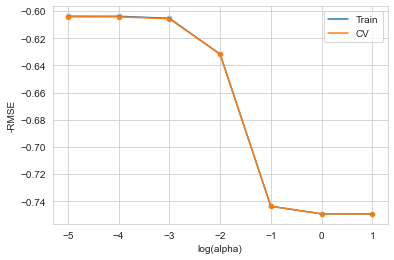

In [55]:
'''DISPLAYING THE RESULTS'''
results = pd.DataFrame(reg_l1.cv_results_)
results = results.sort_values(['param_alpha'])

train_score=results["mean_train_score"] #STORING TRAINING DATASET AUC SCORE
cv_score=results["mean_test_score"] #STORING CV DATESET AUC SCORE
alpha=results["param_alpha"].apply(lambda x:np.log10(x))

sns.set_style("whitegrid")
sns.lineplot(x=alpha,y=train_score,label="Train")
sns.lineplot(x=alpha,y=cv_score,label="CV")
sns.scatterplot(x=alpha,y=train_score)
sns.scatterplot(x=alpha,y=cv_score)
plt.xlabel("log(alpha)")
plt.ylabel("-RMSE")
plt.legend()
plt.show()

In [56]:
# BEST PARAMETERS
reg_l1.best_params_

{'alpha': 1e-05}

In [57]:
'''TRAINING ON BEST PARAMETERS'''
laso = Lasso(alpha = 10**-5)
laso.fit(x_train,y_train)

Lasso(alpha=1e-05)

In [58]:
# TRAIN PREDICTION
train_pred_l1 = laso.predict(x_train)
# VALIDATION PREDICTION
val_pred_l1 = laso.predict(x_val)

In [59]:
# TRAIN ERROR
np.sqrt(mean_squared_error(y_train,train_pred_l1))

0.6040610765979186

In [60]:
# VALIDATION ERROR
np.sqrt(mean_squared_error(y_val , val_pred_l1))

0.6033472651693828

In [61]:
# TEST PREDICTIONS
laso_predict = pd.DataFrame()
laso_predict["test id"] = df_test.index
laso_predict["price"] = log_to_actual(laso.predict(x_test))
laso_predict.to_csv("laso_predict.csv")
laso_predict

,test id,price
0,0,10.231825
1,1,7.909562
2,2,52.392562
3,3,17.384515
4,4,11.166169
...,...,...
3460720,3460720,10.572569
3460721,3460721,19.229684
3460722,3460722,20.077280
3460723,3460723,19.817579


## 2. Ridge

In [62]:
'''HYPERPARAMETER TUNING'''

ridge = Ridge()
param =  {"alpha":[10**x for x in range(-5,2)]}
reg_l2 = GridSearchCV(ridge,param ,cv=3,verbose=1,return_train_score=True,scoring='neg_root_mean_squared_error',n_jobs=-1)
reg_l2.fit(x_train_s,y_train_s)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

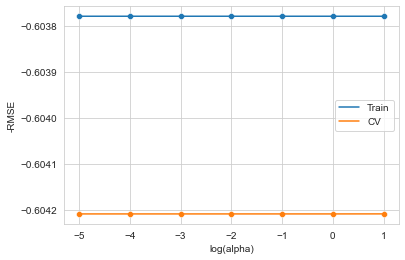

In [63]:
'''DISPLAYING THE BEST RESULTS'''

results = pd.DataFrame(reg_l2.cv_results_)
results = results.sort_values(['param_alpha'])

train_score=results["mean_train_score"] #STORING TRAINING DATASET AUC SCORE
cv_score=results["mean_test_score"] #STORING CV DATESET AUC SCORE
alpha=results["param_alpha"].apply(lambda x:np.log10(x))

sns.set_style("whitegrid")
sns.lineplot(x=alpha,y=train_score,label="Train")
sns.lineplot(x=alpha,y=cv_score,label="CV")
sns.scatterplot(x=alpha,y=train_score)
sns.scatterplot(x=alpha,y=cv_score)
plt.xlabel("log(alpha)")
plt.ylabel("-RMSE")
plt.legend()
plt.show()

In [64]:
# BEST PARAMETERS 
reg_l2.best_params_

{'alpha': 10}

In [65]:
'''TRAINING WITH BEST PARAMETERS'''
ridge_best = Ridge(alpha=10)
ridge_best.fit(x_train,y_train)

Ridge(alpha=10)

In [66]:
# TRAIN PREDICTIONS
train_pred_l2 = ridge_best.predict(x_train)
# VALIDATION PREDICTIONS
val_pred_l2 = ridge_best.predict(x_val)

### Performance

In [67]:
# TRAIN ERROR
np.sqrt(mean_squared_error(y_train , train_pred_l2))

0.604060307943867

In [68]:
#VALIDATION ERROR
np.sqrt(mean_squared_error(y_val , val_pred_l2))

0.6033493205490676

In [69]:
import pickle

In [70]:
# TEST PREDICTION
#ridge= Ridge(alpha=1,solver = "svd", fit_intercept=False )
#ridge.fit(x_train, y_train)
ridge_predict = pd.DataFrame()
ridge_predict["test id"] = df_test.index
ridge_predict["price"] = log_to_actual(reg_l2.predict(x_test))
ridge_predict.to_csv("ridge_predict.csv")
ridge_predict

,test id,price
0,0,10.128337
1,1,7.898854
2,2,53.795877
3,3,17.382129
4,4,11.132957
...,...,...
3460720,3460720,10.562711
3460721,3460721,18.869632
3460722,3460722,20.105930
3460723,3460723,20.171891


## 3. Decision Tree

In [71]:
'''HYPERARAMETER TUNING'''

dt = DecisionTreeRegressor(criterion="mse",max_features="auto")
param =  {"max_depth":[10,50,100,200]}
reg_dt = GridSearchCV(dt,param ,cv=3,verbose=1,return_train_score=True,scoring='neg_root_mean_squared_error',n_jobs=-1)
reg_dt.fit(x_train_s,y_train_s)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(max_features='auto'),
             n_jobs=-1, param_grid={'max_depth': [10, 50, 100, 200]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

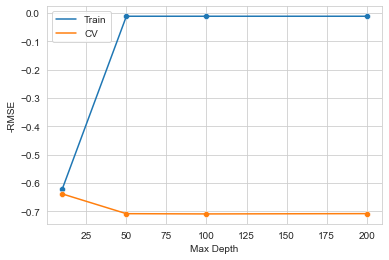

In [72]:
'''DISPLAYING THE RESULTS'''

results = pd.DataFrame(reg_dt.cv_results_)
results = results.sort_values(['param_max_depth'])

train_score=results["mean_train_score"] #STORING TRAINING DATASET AUC SCORE
cv_score=results["mean_test_score"] #STORING CV DATESET AUC SCORE
alpha=results["param_max_depth"]

sns.set_style("whitegrid")
sns.lineplot(x=alpha,y=train_score,label="Train")
sns.lineplot(x=alpha,y=cv_score,label="CV")
sns.scatterplot(x=alpha,y=train_score)
sns.scatterplot(x=alpha,y=cv_score)
plt.xlabel("Max Depth")
plt.ylabel("-RMSE")
plt.legend()
plt.show()

In [73]:
# BEST PARAMETERS
reg_dt.best_params_

{'max_depth': 10}

In [74]:
'''TRAINING WITH THE BEST PARAMETERS'''
dt_best = DecisionTreeRegressor(criterion="mse",max_depth= 10,max_features="auto")
dt_best.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=10, max_features='auto')

In [75]:
# TRAIN PREDICTIONS
train_pred_dt = dt_best.predict(x_train)
# VALIDATION PREDICTIONS
val_pred_dt = dt_best.predict(x_val)

### performance

In [76]:
# TRAIN ERROR
np.sqrt(mean_squared_error(y_train , train_pred_dt))

0.6294674416394338

In [77]:
# VALIDATION ERROR
np.sqrt(mean_squared_error(y_val , val_pred_dt))

0.6359070468699112

In [78]:
# TEST PREDICTIONS
#dt = DecisionTreeRegressor(criterion="mse",max_features="auto")
#dt.fit(x_train, y_train)
dt_predict = pd.DataFrame()
dt_predict["test id"] = df_test.index
dt_predict["price"] = log_to_actual(reg_dt.predict(x_test))
dt_predict.to_csv("dt_predict.csv")
dt_predict

,test id,price
0,0,10.346677
1,1,11.918006
2,2,31.876081
3,3,27.667938
4,4,12.038796
...,...,...
3460720,3460720,11.810429
3460721,3460721,16.435011
3460722,3460722,20.723901
3460723,3460723,20.403031


## 4. Light GBM

validation Loss for parameter 10= 0.6640446830818901
validation Loss for parameter 50= 0.5841201310474317
validation Loss for parameter 100= 0.5579420107452305
validation Loss for parameter 200= 0.5371297488546809
validation Loss for parameter 500= 0.5201914939216762
validation Loss for parameter 1000= 0.5105624689873889
validation Loss for parameter 1200= 0.5085326946393235


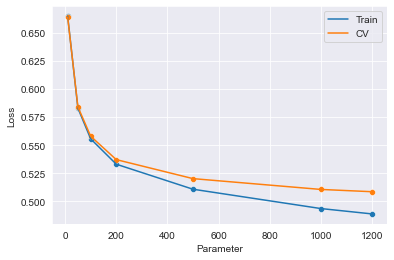

In [79]:
'''HYPERPARAMETER TUNING '''
param =  [10,50,100,200,500,1000,1200]
train_error_list = [] # FOR STORING TRAIN ERROR
val_error_list = [] # FOR STORING VALIDATION ERROR

# FOR EACH PARAMETER
for i in param:
    # TRAIN THE MODEL
    lgb = LGBMRegressor(  n_estimators = i , n_jobs=-1 )
    lgb.fit(x_train_s,y_train_s)
    # PREDICT THE RESULTS
    train_pred = lgb.predict(x_train)
    val_pred = lgb.predict(x_val)
    # COMPUTING THE ERROR
    train_error = np.sqrt(mean_squared_error(y_train,train_pred))
    val_error = np.sqrt(mean_squared_error(y_val,val_pred))
    # APPENGING THE RESULTS 
    train_error_list.append(train_error)
    val_error_list.append(val_error)
    
    print(f"validation Loss for parameter {i}=",val_error)
# PLOTTING THE RESULTS
sns.set_style("darkgrid")
sns.lineplot(x=param,y=train_error_list,label="Train")
sns.scatterplot(x=param,y=train_error_list)
sns.lineplot(x=param,y=val_error_list,label="CV")
sns.scatterplot(x=param,y=val_error_list)
plt.xlabel("Parameter")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [80]:
'''TRAINIG WITH BEST PARAMETER'''

start_time = time.time()
lgb = LGBMRegressor(  n_estimators = 1200 , n_jobs=-1 )
lgb.fit(x_train,y_train)
print("Time Taken= ",round(time.time()-start_time,2),"s")

Time Taken=  600.44 s


In [81]:
'''PREDICTING THE RESULTS'''

train_pred_lgb = lgb.predict(x_train)
val_pred_lgb = lgb.predict(x_val)

### Performance

In [82]:
# TRAIN ERROR
np.sqrt(mean_squared_error(y_train ,train_pred_lgb))

0.47790344352875724

In [83]:
# VALIDATION ERROR
np.sqrt(mean_squared_error(y_val , val_pred_lgb))

0.4994332719431563

In [84]:
# TEST PREDICTIONS
lgb_predict = pd.DataFrame()
lgb_predict["test id"] = df_test.index
lgb_predict["price"] = log_to_actual(lgb.predict(x_test))
lgb_predict.to_csv("lgb_predict.csv")
lgb_predict

,test id,price
0,0,8.018866
1,1,9.729848
2,2,49.393582
3,3,16.032278
4,4,7.148574
...,...,...
3460720,3460720,11.098061
3460721,3460721,21.113379
3460722,3460722,16.883761
3460723,3460723,24.627922


# 2. Feature Engineering

## Categorical Data : One Hot Encoding

## Text data : Tfidf

## Categorical Data

### 1. item_condition_id

In [85]:
'''ITEM CONDITION ID ONE HOT ENDODING '''

train_vec_item_con = pd.get_dummies(df_train.item_condition_id).values
val_vec_item_con = pd.get_dummies(df_val.item_condition_id).values

In [86]:
print(train_vec_item_con.shape)
print(val_vec_item_con.shape)

(1334281, 5)
(148254, 5)


In [87]:
test_vec_item_con = pd.get_dummies(df_test.item_condition_id).values
print(test_vec_item_con.shape)

(3460725, 5)


### 2. shipping

In [88]:
'''SHIPPING ONE HOT ENCODING'''

train_vec_shipping = pd.get_dummies(df_train.shipping).values
val_vec_shipping = pd.get_dummies(df_val.shipping).values

In [89]:
print(train_vec_shipping.shape)
print(val_vec_shipping.shape)

(1334281, 2)
(148254, 2)


In [90]:
test_vec_shipping = pd.get_dummies(df_test.shipping).values
print(test_vec_shipping.shape)

(3460725, 2)


### 3. brand_name

In [91]:
'''BRAND NAME ONE HOT ENCODING'''

label_brand = OneHotEncoder(handle_unknown="ignore")
label_brand.fit(df_train.brand_name_processed.values.reshape(-1,1))

train_vec_brand =label_brand.transform(df_train.brand_name_processed.values.reshape(-1,1))
val_vec_brand = label_brand.transform(df_val.brand_name_processed.values.reshape(-1,1))

print(train_vec_brand.shape)
print(val_vec_brand.shape)

(1334281, 4702)
(148254, 4702)


In [92]:
test_vec_brand = label_brand.transform(df_test.brand_name_processed.values.reshape(-1,1))
print(test_vec_brand.shape)

(3460725, 4702)


### 4. Tier_1

In [93]:
'''TIER1 ONE HOT ENCODING'''

label_t1 = OneHotEncoder(handle_unknown='ignore')
label_t1.fit(df_train.Tier_1.values.reshape(-1,1))

train_vec_t1 = label_t1.transform(df_train.Tier_1.values.reshape(-1,1))
val_vec_t1 =   label_t1.transform(df_val.Tier_1.values.reshape(-1,1))


print(train_vec_t1.shape)
print(val_vec_t1.shape)

(1334281, 11)
(148254, 11)


In [94]:
test_vec_t1 =   label_t1.transform(df_test.Tier_1.values.reshape(-1,1))
print(test_vec_t1.shape)

(3460725, 11)


### 5. Tier_2

In [95]:
'''TIER2 ONE HOT ENCODING'''

label_t2 = OneHotEncoder(handle_unknown='ignore')
label_t2.fit(df_train.Tier_2.values.reshape(-1,1))

train_vec_t2 =label_t2.transform(df_train.Tier_2.values.reshape(-1,1))
val_vec_t2 = label_t2.transform(df_val.Tier_2.values.reshape(-1,1))

print(train_vec_t2.shape)
print(val_vec_t2.shape)

(1334281, 111)
(148254, 111)


In [96]:
test_vec_t2 = label_t2.transform(df_test.Tier_2.values.reshape(-1,1))
test_vec_t2.shape

(3460725, 111)

### 6. Tier_3

In [97]:
'''TIER 3 ONE HOT ENDODING'''

label_t3 = OneHotEncoder(handle_unknown='ignore')
label_t3.fit(df_train.Tier_3.values.reshape(-1,1))

train_vec_t3 =label_t3.transform(df_train.Tier_3.values.reshape(-1,1))
val_vec_t3 = label_t3.transform(df_val.Tier_3.values.reshape(-1,1))
#
print(train_vec_t3.shape)
print(train_vec_t3.shape)


(1334281, 863)
(1334281, 863)


In [98]:
'''FEATURIZING THE TEST DATASET'''

test_vec_t3 = label_t3.transform(df_test.Tier_3.values.reshape(-1,1))
test_vec_t3.shape

(3460725, 863)

## Text Data

## Tfidf

### 7. name_processed

In [99]:
'''PROCESSED NAME TFIDF VECTORIZER'''

tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=50000,encoding='utf-8')
tfidf.fit(df_train.name_processed.values.astype('U'))

train_vec_name = tfidf.transform((df_train.name_processed).values.astype('U'))
val_vec_name = tfidf.transform((df_val.name_processed).values.astype('U'))


print(train_vec_name.shape)
print(val_vec_name.shape)

(1334281, 50000)
(148254, 50000)


In [100]:
'''VECTORIZATION OF PROCESSED NAME IN  TEST DATASET '''

test_vec_name = tfidf.transform(df_test.name_processed)
print(test_vec_name.shape)

(3460725, 50000)


### 8. processed_item_description

In [101]:
'''PROCESSED ITEM DESCRIPTION TFIDF VECTORIZATION'''

tfidf_desc = TfidfVectorizer(max_features=50000,ngram_range=(1, 2))
tfidf_desc.fit(df_train.processed_item_description)

train_vec_desc = tfidf_desc.transform(df_train.processed_item_description  )
val_vec_desc   = tfidf_desc.transform(df_val.processed_item_description)


print(train_vec_desc.shape)
print(val_vec_desc.shape)

(1334281, 50000)
(148254, 50000)


In [102]:
'''TEST DATASET PROCESSED ITEM DESCRIPTION TFIDF VECTOR'''

test_vec_desc   = tfidf_desc.transform(df_test.processed_item_description.values.astype('U'))
print(test_vec_desc.shape)

(3460725, 50000)


### 9. is_missing

In [103]:
'''IS MISSIN FEATURE FOR TRAIN DATASET'''

df_train["is_missing"]  =  (df_train.brand_name_processed=="missing") | (df_train.name_processed =="missing")| (df_train.processed_item_description=="missing")
df_train["is_missing"]  = df_train["is_missing"].astype(int)

In [104]:
'''IS MISSING FEATURE FOR VALIDATION DATASET'''

df_val["is_missing"]  =  (df_val.brand_name_processed=="missing") | (df_val.name_processed =="missing")| (df_val.processed_item_description=="missing")
df_val["is_missing"]  = df_val["is_missing"].astype(int)

In [105]:
'''IS MISSING FEATURE FOR TEST DATASET'''

df_test["is_missing"]  =  (df_test.brand_name_processed=="missing") | (df_test.name_processed =="missing")| (df_test.processed_item_description=="missing")
df_test["is_missing"]  = df_test["is_missing"].astype(int)

## Concatenating

In [106]:
'''STACKING ALL THE FEATURES'''


# STACKING TRAIN FEATURES
x_train = hstack((train_vec_item_con,train_vec_shipping,
                  train_vec_name,train_vec_brand,train_vec_t1,
                   train_vec_t2,
                    train_vec_t3,
                  df_train.is_missing.values.reshape(-1,1)
                   ,train_vec_desc))


# STACKING VALIDATION FEATURES
x_val = hstack((val_vec_item_con,val_vec_shipping
                ,val_vec_name ,val_vec_brand ,val_vec_t1 ,\
                  val_vec_t2 ,val_vec_t3 ,
                df_val.is_missing.values.reshape(-1,1)
                ,val_vec_desc))

# STACKING TEST FEATURES
x_test = hstack((test_vec_item_con,test_vec_shipping
                ,test_vec_name ,test_vec_brand ,test_vec_t1 ,\
                  test_vec_t2 ,test_vec_t3 ,
                df_test.is_missing.values.reshape(-1,1)
                ,test_vec_desc))

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1334281, 105695)
(148254, 105695)
(3460725, 105695)


# C. Models

## Linear regression

In [107]:
'''TRAINING LINEAR REGERSSION'''

lr = LinearRegression(normalize=True)
lr.fit(x_train,y_train)

LinearRegression(normalize=True)

In [108]:
# TRAIN PREDICTION
train_pred_lr = lr.predict(x_train)
# VALIDATION PREDICTION
val_pred_lr = lr.predict(x_val)

In [109]:
# TRAIN ERROR
train_error = np.sqrt(mean_squared_error(y_train,train_pred_lr))
print("Train Error",train_error)
# TEST ERROR
val_error = np.sqrt(mean_squared_error(y_val,val_pred_lr))
print("Validation Error",val_error)

Train Error 0.424085676924213
Validation Error 0.46200501816414163


In [110]:
# TEST PREDICTION
lr_predict = pd.DataFrame()
lr_predict["test id"] = df_test.index
lr_predict["price"] = log_to_actual(lr.predict(x_test))
lr_predict.to_csv("linear_tfidf_predict.csv")
lr_predict

,test id,price
0,0,9.421827
1,1,6.430580
2,2,43.903804
3,3,17.423701
4,4,7.696463
...,...,...
3460720,3460720,10.841812
3460721,3460721,45.799954
3460722,3460722,18.338052
3460723,3460723,22.851735


## Ridge

validation Loss for parameter {i}= 0.46059875576083315
validation Loss for parameter {i}= 0.46053633666361515
validation Loss for parameter {i}= 0.4605303736439473
validation Loss for parameter {i}= 0.46043163859141784
validation Loss for parameter {i}= 0.45988014847737246
validation Loss for parameter {i}= 0.4568448717134031
validation Loss for parameter {i}= 0.45810613134388256
validation Loss for parameter {i}= 0.4850253685990414
validation Loss for parameter {i}= 0.5384689138424145
validation Loss for parameter {i}= 0.6099330524786071
validation Loss for parameter {i}= 0.6738959568056672


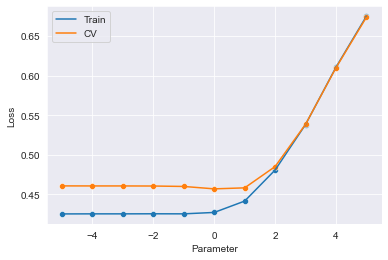

In [111]:
'''HYPERPARAMETER TUNING '''

param =  [10**x for x in range(-5,6)]
train_error_list = [] # STORING TRAIN ERROR
val_error_list = [] # STORING VALIDATION ERROR

# FOR EACH PARAMETER
for i in param:
    # TRAIN THE PARAMETER
    l2 = Ridge(alpha=i, random_state=241)
    l2.fit(x_train,y_train)
    # PREDICT THE RESULTS
    train_pred = l2.predict(x_train)
    val_pred = l2.predict(x_val)
    # COMPUTE THE ERROR
    train_error = np.sqrt(mean_squared_error(y_train,train_pred))
    val_error = np.sqrt(mean_squared_error(y_val,val_pred))
    # APPEND THE ERROR
    train_error_list.append(train_error)
    val_error_list.append(val_error)
    # PRINT THE RESULTS
    print("validation Loss for parameter {i}=",val_error)
# SHOW THE RESULTS
log_param = np.log10(np.array(param))
sns.set_style("darkgrid")
sns.lineplot(x=log_param,y=train_error_list,label="Train")
sns.scatterplot(x=log_param,y=train_error_list)
sns.lineplot(x=log_param,y=val_error_list,label="CV")
sns.scatterplot(x=log_param,y=val_error_list)
plt.xlabel("Parameter")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [112]:
# best_alpha = 10
'''TRAINING WITH BEST PARAMETERS'''

l2_best = Ridge(alpha=10)
l2_best.fit(x_train,y_train)

Ridge(alpha=10)

In [113]:
# TRAIN PREDICTION
train_pred = l2_best.predict(x_train)
# VALIDATION PREDICTION
val_pred = l2_best.predict(x_val)

In [114]:
# TRAIN ERROR
train_error = np.sqrt(mean_squared_error(y_train,train_pred))
print("Train Error = ",train_error)
# VALIDATION ERROR
val_error = np.sqrt(mean_squared_error(y_val,val_pred))
print("Validation Error = ",val_error)

Train Error =  0.4413924331011221
Validation Error =  0.45810613134388256


In [115]:
# TEST PREDICTIONS
ridge_predict = pd.DataFrame()
ridge_predict["test id"] = df_test.index
ridge_predict["price"] = log_to_actual(l2_best.predict(x_test))
ridge_predict.to_csv("ridge_tfidf_predict.csv")
ridge_predict

,test id,price
0,0,9.116746
1,1,9.133506
2,2,42.380197
3,3,16.781443
4,4,7.520939
...,...,...
3460720,3460720,9.657800
3460721,3460721,32.744726
3460722,3460722,17.703741
3460723,3460723,21.511721


# Model Comparision 

In [116]:
res = pd.DataFrame()
res["Model"] = ["Benchmark","Lasso","Ridge","Decision Tree","Light GBM","linear Regression","Ridge"]
res["Feature Type"] = ["-","Label Endoing+Word2Vec","Label Endoing+Word2Vec","Label Endoing+Word2Vec","Label Endoing+Word2Vec","One hot endoding + Tfidf", "One hot endoding + Tfidf"]
res["Best Param"] = ["-",1e-5,10,10,1200,"-",10]
res["Train Error"] = [0.7267,0.6044,0.6044,0.6231,0.4778,0.4240,0.4413]
res["Validation Error"] = [0.7254,0.6037,0.6037,0.6311,0.4992,0.4620,0.4581]
res["Test Error"] = [0.72753,0.60518,0.60518,0.6370,0.50050,0.46210,0.45831]
res

,Model,Feature Type,Best Param,Train Error,Validation Error,Test Error
0,Benchmark,-,-,0.7267,0.7254,0.72753
1,Lasso,Label Endoing+Word2Vec,0.00001,0.6044,0.6037,0.60518
2,Ridge,Label Endoing+Word2Vec,10,0.6044,0.6037,0.60518
3,Decision Tree,Label Endoing+Word2Vec,10,0.6231,0.6311,0.63700
4,Light GBM,Label Endoing+Word2Vec,1200,0.4778,0.4992,0.50050
5,linear Regression,One hot endoding + Tfidf,-,0.4240,0.4620,0.46210
6,Ridge,One hot endoding + Tfidf,10,0.4413,0.4581,0.45831
